# GAN

Some description.....

## Table of Contents

## Import

In [32]:
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

from IPython import display
import imageio
import glob
import tqdm
import PIL


## Load and prepare the dataset

### Download images

### Load images

In [3]:
images = np.load(f'npy_files/candle.npy')

### Data pipeline

In [4]:
def prepare_data(images, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(images.reshape(len(images), 28, 28, 1))
    ds.map(lambda x: (tf.cast(x, float)))
    ds = ds.map(lambda x: (x/255))
    ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [5]:
train_ds = prepare_data(images[:int(len(images)*0.8)], 32)
val_ds = prepare_data(images[int(len(images)*0.8)+1:], 32)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-01-21 11:15:39.864800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-21 11:15:39.864951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Plot some images

10


2023-01-21 11:15:41.419034: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


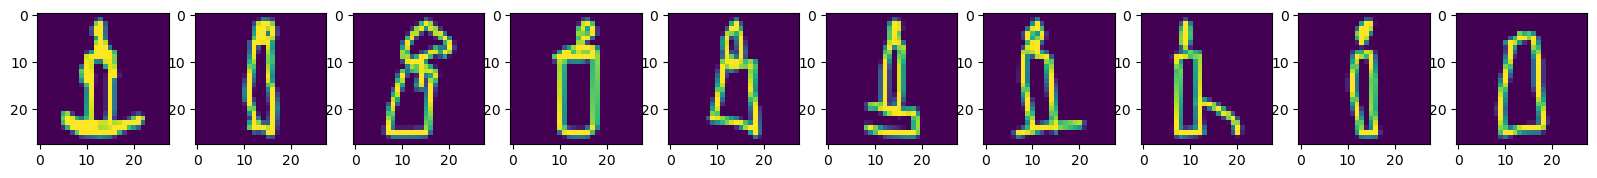

In [6]:
def plot(data):   
    n = len(data)
    plt.figure(figsize=(20, 5))
    for img in data:
        for i in range(n):
            ax = plt.subplot(2,n,i+1)
            plt.imshow(img[i].numpy())
        #for i in range(n):
        #    ax = plt.subplot(2, n, i+n+1)
        #    plt.hist(img[i].numpy().ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
    plt.show()

data = train_ds.take(10)
print(len(data))
plot(data)

## Discriminator

In [7]:
class Discriminator(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Discriminator, self).__init__()
    #inherit functionality from parent class

    self.layers_list = [
      #tf.keras.layers.Input(shape=(32,28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28,28,1)), # (batch, 14,14,filters=32)
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), # (batch, 7,7, filters=32)
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(1, activation='softmax')
    ]

  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

## Generator

In [8]:
class Generator(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Generator, self).__init__()
    #inherit functionality from parent class

    self.layers_list = [
        
        tf.keras.layers.Dense(7*7*32, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Reshape((7,7,32)),

        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same'), # (batch, 14,14,32)
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same'), # (batch, 28,28,32)
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same') # (batch, 28, 28, 1)
    ]

  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

## GAN

In [18]:
class GAN(tf.keras.Model):
  
    #1 Constructor
    def __init__(self):
        super(GAN, self).__init__()
        #inherit functionality from parent class

        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        self.loss = tf.keras.losses.BinaryCrossentropy()
        
        # list of metrics to track the performance of the generator
        self.gen_metrics_list = [tf.keras.metrics.Mean(name="gen_loss"),
                            tf.keras.metrics.Accuracy(name="gen_acc")
                           ]

        # list of metrics to track the performance of the discriminator with real images as the input
        self.disc_metrics_list_real = [tf.keras.metrics.Mean(name="disc_loss_real"),
                                    tf.keras.metrics.Accuracy(name="disc_acc_real")
        ]

        # list of metrics to track the performance of the discriminator with fake (generated) images as the input
        self.disc_metrics_list_fake = [tf.keras.metrics.Mean(name="disc_loss_fake"),
                                    tf.keras.metrics.Accuracy(name="disc_acc_fake")
        ]

        self.discriminator = Discriminator()
        self.generator = Generator()

    def get_discriminator(self):
        return self.discriminator

    def get_generator(self):
        return self.generator

    # seperately definifined loss functions for discriminator and generator
    def discriminator_loss(self, disc_output_real_imgs, disc_output_fake_imgs):
        real_imgs_loss = self.loss(tf.ones_like(disc_output_real_imgs), disc_output_real_imgs)
        fake_imgs_loss = self.loss(tf.zeros_like(disc_output_fake_imgs), disc_output_fake_imgs)
        return (real_imgs_loss,fake_imgs_loss)

    def generator_loss(self, disc_output_fake_imgs):
        return self.loss(tf.ones_like(disc_output_fake_imgs), disc_output_fake_imgs)

    #3. metrics property
    @property
    def get_metrics(self):
        # return a list with all metrics in the model
        return [self.gen_metrics_list, self.disc_metrics_list_real, self.disc_metrics_list_fake]


    #4 reset all metrics object
    def reset_metrics(self):
        for metric_list in self.get_metrics:
            for metric in metric_list:
                metric.reset_states()

    #5 training step method
    def train_step(self, data, noise_dim):
        # update the state of the metrics according to loss
        # return a dictionary with metrics name as keys an metric results
        noise = tf.random.normal([32, noise_dim])
        real_imgs = data

        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            
            fake_imgs = self.generator(noise, training=True) # generate fake images
            disc_output_real_imgs = self.discriminator(real_imgs, training=True) # classify real images
            disc_output_fake_imgs = self.discriminator(fake_imgs, training=True) # classify fake images

            gen_loss = self.generator_loss(disc_output_fake_imgs) # returns loss of the generator
            disc_loss_real, disc_loss_fake = self.discriminator_loss(disc_output_real_imgs, disc_output_fake_imgs) # returns losses for discriminitor with real images and fake images respectively 
            disc_loss = disc_loss_real + disc_loss_fake # add both losses of discriminator together to obtain total loss

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables) # get gradients of generator
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables) # get gradients of discriminator

        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables)) # apply gradients to generator
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables)) # apply gradients to discriminator

        #update the state of the metrics according to loss
        self.gen_metrics_list[0].update_state(gen_loss)
        self.disc_metrics_list_fake[0].update_state(disc_loss_fake)
        self.disc_metrics_list_real[0].update_state(disc_loss_real)

        self.gen_metrics_list[1].update_state(tf.ones_like(disc_output_fake_imgs), disc_output_fake_imgs)
        self.disc_metrics_list_fake[1].update_state(tf.zeros_like(disc_output_fake_imgs), disc_output_fake_imgs)
        self.disc_metrics_list_real[1].update_state(tf.ones_like(disc_output_real_imgs), disc_output_real_imgs)


        # return a dictionary with metric names as keys and metric results as values
        # what exactly is written in the self.metrics variable?

        return {m.name : m.result() for metrics_list in self.get_metrics for m in metrics_list}
    

    #6. test step method
    def test_step(self, data, noise_dim):
        noise = tf.random.normal([32, noise_dim])
        real_imgs = data
        
        fake_imgs = self.generator(noise, training=True) # generate fake images
        disc_output_real_imgs = self.discriminator(real_imgs, training=True) # classify real images
        disc_output_fake_imgs = self.discriminator(fake_imgs, training=True) # classify fake images
        
        
        gen_loss = self.generator_loss(disc_output_fake_imgs) # returns loss of the generator
        disc_loss_real, disc_loss_fake = self.discriminator_loss(disc_output_real_imgs, disc_output_fake_imgs) # returns losses for discriminitor with real images and fake images respectively 
        disc_loss = disc_loss_real + disc_loss_fake # add both losses of discriminator together to obtain total loss
        
        #update the state of the metrics according to loss
        self.gen_metrics_list[0].update_state(gen_loss)
        self.disc_metrics_list_fake[0].update_state(disc_loss_fake)
        self.disc_metrics_list_real[0].update_state(disc_loss_real)

        self.gen_metrics_list[1].update_state(tf.ones_like(disc_output_fake_imgs), disc_output_fake_imgs)
        self.disc_metrics_list_fake[1].update_state(tf.zeros_like(disc_output_fake_imgs), disc_output_fake_imgs)
        self.disc_metrics_list_real[1].update_state(tf.ones_like(disc_output_real_imgs), disc_output_real_imgs)

        return {"val_"+m.name : m.result() for metrics_list in self.get_metrics for m in self.metrics}


    

## Create images during training

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


## Training loop

In [21]:
def training_loop(model, train_ds, val_ds, noise_dim, epochs, train_summary_writer, val_summary_writer, save_path):
  #1. iterate over epochs
  for e in range(epochs):
    
    #2. train steps on all batchs in the training data
    for data in tqdm.tqdm(train_ds):
      metrics = model.train_step(data, noise_dim)
    
    # 3. log and print data metrics
    with train_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

    
    display.clear_output(wait=True)
    seed = tf.random.normal([16, noise_dim])
    generate_and_save_images(model.get_generator(), e+1, seed)

    #4 reset the metrics
    model.reset_metrics()

    #5. evaluate on validation data
    for data in val_ds:
      metrics = model.test_step(data, noise_dim)
    
    #6. log validation metrics
    with val_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    #7. reset metric objects
    model.reset_metrics()

  #8 save model weights
  model.save_weights(save_path)

## Summary writer

In [22]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

## Model 1

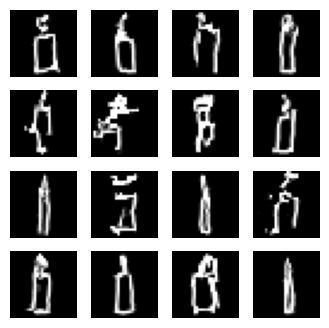

Mean(name=gen_loss,dtype=float32)
Accuracy(name=gen_acc,dtype=float32)
Mean(name=disc_loss_real,dtype=float32)
Accuracy(name=disc_acc_real,dtype=float32)
Mean(name=disc_loss_fake,dtype=float32)
Accuracy(name=disc_acc_fake,dtype=float32)
['val_gen_loss: 1.881317377090454', 'val_gen_acc: 1.0', 'val_disc_loss_real: 0.44380131363868713', 'val_disc_acc_real: 1.0000001192092896', 'val_disc_loss_fake: 0.35677850246429443', 'val_disc_acc_fake: 0.0']


In [28]:
#1. instantiate model
model = GAN() # this model has sigmoid as the activation function of the dense layer of the decoder
#model(tf.keras.Input((28,28,1)))
#model.summary()
epochs=10
noise_dim = 100

#2. choose a path to save the weights
save_path = "trained_model"

training_loop(model, train_ds,val_ds, noise_dim, epochs, train_summary_writer, val_summary_writer, save_path)

## Create a GIF

In [33]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


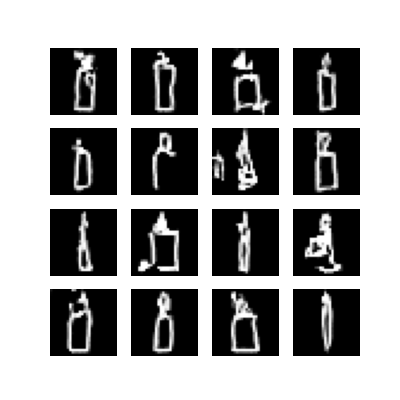

In [36]:
display_image(3)

In [29]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  


/var/folders/2q/hwnn9141093b7bkbnd4bm7tc0000gn/T/ipykernel_62284/2104173274.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



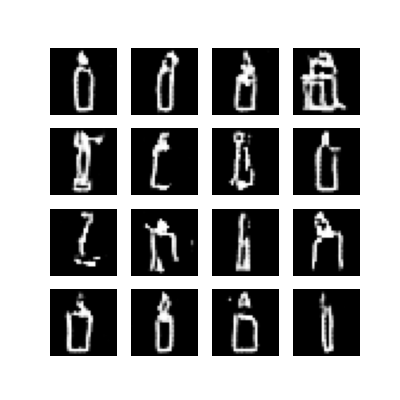

In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)